In [334]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [225]:
train_df=pd.read_csv('./playground-series-s5e5/train.csv')
test_df=pd.read_csv('./playground-series-s5e5/test.csv')

In [226]:
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [227]:
test_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [228]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (750000, 9)
Test shape: (250000, 8)


In [229]:
train_df.isna().mean()*100

id            0.0
Sex           0.0
Age           0.0
Height        0.0
Weight        0.0
Duration      0.0
Heart_Rate    0.0
Body_Temp     0.0
Calories      0.0
dtype: float64

In [230]:
test_df.isna().mean()*100

id            0.0
Sex           0.0
Age           0.0
Height        0.0
Weight        0.0
Duration      0.0
Heart_Rate    0.0
Body_Temp     0.0
dtype: float64

In [231]:
test_ids=test_df['id']

In [232]:
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

In [233]:
def get_iqr_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def cap_outliers_with_bounds(df, column, lower_bound, upper_bound):
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
for col in numerical_cols:
    lower, upper = get_iqr_bounds(train_df, col)
    train_df = cap_outliers_with_bounds(train_df, col, lower, upper)
    test_df = cap_outliers_with_bounds(test_df, col, lower, upper)

In [234]:
def detecting_outliers(val):
    sns.boxplot(x=f'{val}', data=train_df)
    plt.title("Box plot")
    plt.show()

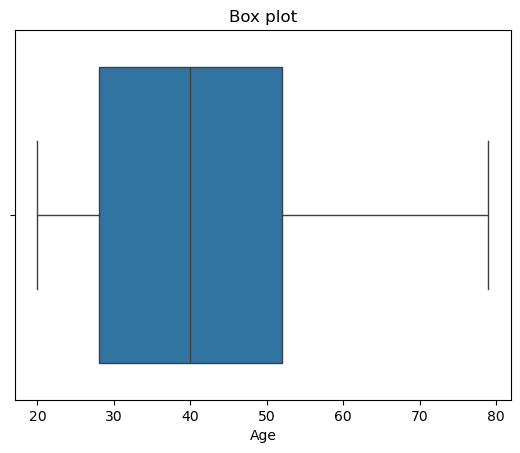

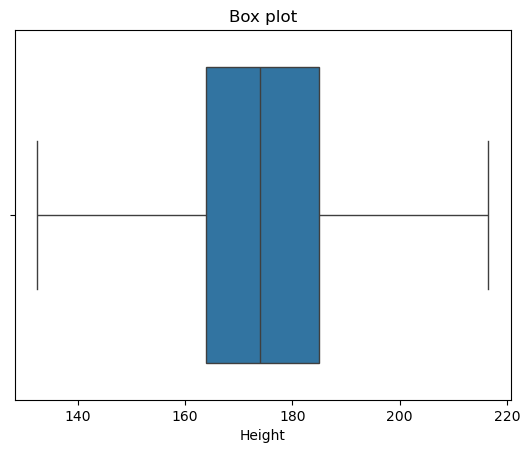

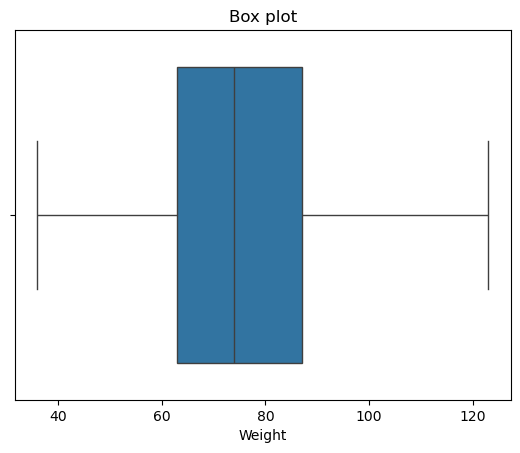

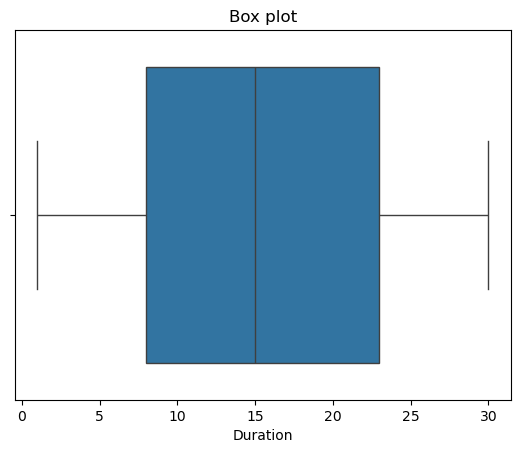

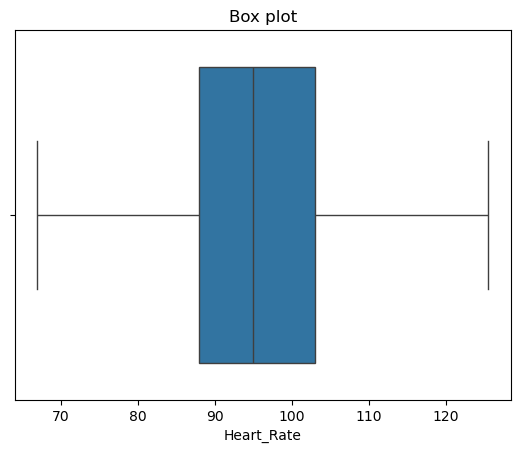

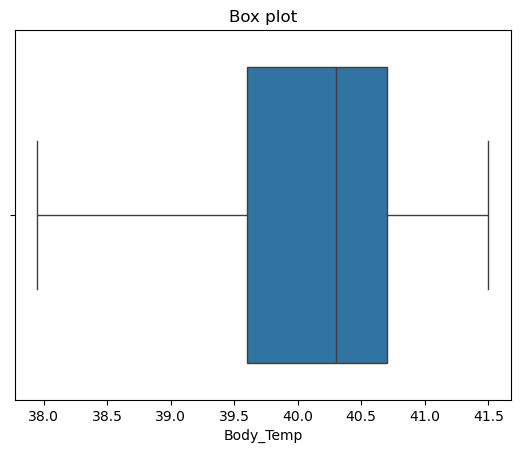

In [235]:
detecting_outliers('Age')
detecting_outliers('Height')
detecting_outliers('Weight')
detecting_outliers('Duration')
detecting_outliers('Heart_Rate')
detecting_outliers('Body_Temp')

In [236]:
train_df['Duration^2']=train_df['Duration']**2
train_df['Age_bin']=pd.cut(train_df['Age'], bins=[19, 25, 30, 40, 50, 60, 70, 80], labels=False)

test_df['Duration^2']=test_df['Duration']**2
test_df['Age_bin']=pd.cut(test_df['Age'], bins=[19, 25, 30, 40, 50, 60, 70, 80], labels=False)

In [237]:
train_df.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration^2,Age_bin
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0,676.0,2
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0,64.0,5
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0,49.0,4
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0,625.0,0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0,625.0,2


In [238]:
test_df.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Duration^2,Age_bin
0,male,45,177.0,81.0,7.0,87.0,39.8,49.0,3
1,male,26,200.0,97.0,20.0,101.0,40.5,400.0,1
2,female,29,188.0,85.0,16.0,102.0,40.4,256.0,1
3,female,39,172.0,73.0,20.0,107.0,40.6,400.0,2
4,female,30,173.0,67.0,16.0,94.0,40.5,256.0,1


In [269]:
X=train_df.drop(columns='Calories')
y=train_df['Calories']

In [271]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [273]:
y_train_log=np.log1p(y_train)
y_test_log=np.log1p(y_test)

In [267]:
train_df['Sex']=train_df['Sex'].apply(lambda x: 1 if x=="male" else 0)
test_df['Sex']=test_df['Sex'].apply(lambda x: 1 if x=="male" else 0)

In [275]:
scaler=StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

test_df_scaled=scaler.transform(test_df)

In [277]:
cat_model=CatBoostRegressor()
cat_model.fit(X_train_scaled, y_train_log)

Learning rate set to 0.112494
0:	learn: 0.8615240	total: 51.5ms	remaining: 51.5s
1:	learn: 0.7723279	total: 67.5ms	remaining: 33.7s
2:	learn: 0.6932515	total: 86.2ms	remaining: 28.6s
3:	learn: 0.6231202	total: 102ms	remaining: 25.4s
4:	learn: 0.5607181	total: 115ms	remaining: 22.9s
5:	learn: 0.5045848	total: 133ms	remaining: 22.1s
6:	learn: 0.4548652	total: 147ms	remaining: 20.8s
7:	learn: 0.4102776	total: 161ms	remaining: 19.9s
8:	learn: 0.3709407	total: 175ms	remaining: 19.2s
9:	learn: 0.3360504	total: 192ms	remaining: 19s
10:	learn: 0.3049324	total: 208ms	remaining: 18.7s
11:	learn: 0.2774194	total: 222ms	remaining: 18.3s
12:	learn: 0.2534855	total: 233ms	remaining: 17.7s
13:	learn: 0.2321054	total: 244ms	remaining: 17.2s
14:	learn: 0.2130207	total: 256ms	remaining: 16.8s
15:	learn: 0.1962159	total: 267ms	remaining: 16.4s
16:	learn: 0.1814025	total: 278ms	remaining: 16s
17:	learn: 0.1679114	total: 291ms	remaining: 15.9s
18:	learn: 0.1560128	total: 306ms	remaining: 15.8s
19:	learn: 0

In [278]:
cat_pred=cat_model.predict(X_test_scaled)
cat_pred=np.expm1(cat_pred)

In [279]:
rmsle = np.sqrt(mean_squared_log_error(y_test, cat_pred))
print("CatBoost RMSLE:", rmsle)

CatBoost RMSLE: 0.06826594176298889


In [280]:
lgb_model=lgb.LGBMRegressor()
lgb_model.fit(X_train_scaled, y_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 8
[LightGBM] [Info] Start training from score 4.141905


LGBMRegressor()

In [281]:
lgb_pred_log=lgb_model.predict(X_test_scaled)
lgb_pred=np.expm1(lgb_pred_log)

In [282]:
rmsle = np.sqrt(mean_squared_log_error(y_test, lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.07055083843178765


### Let's trynna optimize lightgbm

In [284]:
rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'n_estimators': np.arange(50, 500, 50),
}

In [285]:
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring=rmsle_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [286]:
random_search.fit(X_train_scaled, y_train_log)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 388
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 8
[LightGBM] [Info] Start training from score 4.141147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 8
[LightGBM] [Info] Start training from score 4.142610
[LightGBM] [Info] Auto-choosing row-wise multi-thread

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01      , 0.02526316, 0.04052632, 0.05578947, 0.07105263,
       0.08631579, 0.10157895, 0.11684211, 0.13210526, 0.14736842,
       0.16263158, 0.17789474, 0.19315789, 0.20842105, 0.22368421,
       0.23894737, 0.25421053, 0.26947368, 0.28473684, 0.3       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]),
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
                   random_state=42,
                   scoring=make_scorer(mean_squared_log_error, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [287]:
print("Best Params:", random_search.best_params_)
print("Best RMSLE:", np.sqrt(-random_search.best_score_))

Best Params: {'num_leaves': 140, 'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.07105263157894737}
Best RMSLE: 0.01929000117671741


In [288]:
final_lgb_model = LGBMRegressor(
    num_leaves=140,
    n_estimators=250,
    max_depth=8,
    learning_rate=0.07105,
    random_state=42
)

final_lgb_model.fit(X_train_scaled, y_train_log)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 8
[LightGBM] [Info] Start training from score 4.141905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(learning_rate=0.07105, max_depth=8, n_estimators=250,
              num_leaves=140, random_state=42)

In [289]:
y_pred_log=final_lgb_model.predict(X_test_scaled)
final_lgb_pred=np.expm1(y_pred_log)

In [290]:
rmsle = np.sqrt(mean_squared_log_error(y_test, final_lgb_pred))
print("LightGBM RMSLE:", rmsle)

LightGBM RMSLE: 0.06877557113404512


In [291]:
rmsle_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [292]:
param_dist = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': np.arange(3, 15),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'gamma': np.linspace(0, 5, 10),
    'reg_alpha': np.linspace(0, 1.0, 10),
    'reg_lambda': np.linspace(0, 1.0, 10),
}

In [293]:
xgb = XGBRegressor(random_state=42)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring=rmsle_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_scaled, y_train_log)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                   verbose=1)

In [294]:
print("Best Params:", random_search_xgb.best_params_)
print("Best RMSLE:", np.sqrt(-random_search_xgb.best_score_))

Best Params: {'subsample': 0.8, 'reg_lambda': 0.2222222222222222, 'reg_alpha': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1931578947368421, 'gamma': 0.0, 'colsample_bytree': 0.9}
Best RMSLE: 0.06910167443520933


In [295]:
final_xgb_model = XGBRegressor(
    subsample=0.8,
    reg_lambda=0.2222,
    reg_alpha=1.0,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.19316,
    gamma=0.0,
    colsample_bytree=0.9,
    random_state=42
)

final_xgb_model.fit(X_train_scaled, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.19316, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [296]:
y_pred_log=final_xgb_model.predict(X_test_scaled)
final_xgb_pred=np.expm1(y_pred_log)

In [297]:
rmsle = np.sqrt(mean_squared_log_error(y_test, final_xgb_pred))
print("XGB RMSLE:", rmsle)

XGB RMSLE: 0.06935425860274445


In [328]:
y_pred_log_cat = cat_model.predict(X_train_scaled)
y_pred_log_lgb = final_lgb_model.predict(X_train_scaled)
y_pred_log_xgb = final_xgb_model.predict(X_train_scaled)

In [330]:
blended_preds_train=0.8 * y_pred_log_cat + 0.1 * y_pred_log_lgb + 0.1 * y_pred_log_xgb

In [336]:
residuals=y_train_log-blended_preds_train

In [338]:
residual_model=Ridge(alpha=1.0)
residual_model.fit(X_train_scaled, residuals)

Ridge()

In [340]:
blended_preds_test=(
    0.8 * cat_model.predict(X_test_scaled) +
    0.1 * final_lgb_model.predict(X_test_scaled) + 
    0.1 * final_xgb_model.predict(X_test_scaled)
)

residual_correction=residual_model.predict(X_test_scaled)

In [342]:
final_preds=blended_preds_test + residual_correction

In [344]:
final_preds=np.expm1(final_preds)

In [348]:
rmsle = np.sqrt(mean_squared_log_error(y_test, final_preds))
print("Blended + Ridge RMSLE:", rmsle)

Blended + Ridge RMSLE: 0.06808985019114684


## GEMINI CODE

In [352]:
# Split the *original* training data to create a validation set
X_train_new, X_val_blend, y_train_new, y_val_blend = train_test_split(
    X_train_scaled, y_train_log, test_size=0.2, random_state=42
)

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

def evaluate_blended_model(weights, X, y_true, cat_model, lgb_model, xgb_model):
    """Evaluates the blended model with given weights on the provided data."""
    cat_preds = cat_model.predict(X)
    lgb_preds = lgb_model.predict(X)
    xgb_preds = xgb_model.predict(X)
    blended_preds = (
        weights[0] * cat_preds +
        weights[1] * lgb_preds +
        weights[2] * xgb_preds
    )
    return rmsle(y_true, blended_preds)

# Let's evaluate your current weights on the validation set
current_weights = [0.8, 0.1, 0.1]
current_rmsle_val = evaluate_blended_model(
    current_weights, X_val_blend, y_val_blend, cat_model, final_lgb_model, final_xgb_model
)
print(f"Current blended model RMSLE on validation set: {current_rmsle_val:.5f}")

Current blended model RMSLE on validation set: 0.06431


In [354]:
from scipy.optimize import minimize

def objective_function(weights, X, y_true, cat_model, lgb_model, xgb_model):
    return evaluate_blended_model(weights, X, y_true, cat_model, lgb_model, xgb_model)

# Define the constraints for the weights (sum to 1, between 0 and 1)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
               {'type': 'ineq', 'fun': lambda w: w[0]},
               {'type': 'ineq', 'fun': lambda w: w[1]},
               {'type': 'ineq', 'fun': lambda w: w[2]})

# Initial guess for the weights
initial_weights = [0.8, 0.1, 0.1]

# Run the optimization
result = minimize(
    objective_function,
    initial_weights,
    args=(X_val_blend, y_val_blend, cat_model, final_lgb_model, final_xgb_model),
    method='SLSQP',  # A suitable optimization method for constrained problems
    bounds=[(0, 1), (0, 1), (0, 1)],
    constraints=constraints
)

optimal_weights_opt = result.x
best_rmsle_opt = result.fun

print(f"\nOptimization Results:")
print(f"Optimal Weights: {optimal_weights_opt}")
print(f"Best RMSLE: {best_rmsle_opt:.5f}")


Optimization Results:
Optimal Weights: [0.59686289 0.         0.40313711]
Best RMSLE: 0.06382


In [357]:
optimized_blended_preds_test = (
    optimal_weights_opt[0] * cat_model.predict(X_test_scaled) +
    optimal_weights_opt[1] * final_lgb_model.predict(X_test_scaled) +
    optimal_weights_opt[2] * final_xgb_model.predict(X_test_scaled)
)

# Don't forget to apply the residual correction if you still want to use it
residual_correction_test = residual_model.predict(X_test_scaled)
final_predictions_optimized = optimized_blended_preds_test + residual_correction_test
final_predictions_optimized = np.expm1(final_predictions_optimized)

# Calculate the RMSLE on the test set (if you have y_test, for local evaluation)
from sklearn.metrics import mean_squared_log_error
rmsle_optimized = np.sqrt(mean_squared_log_error(y_test, final_predictions_optimized))
print(f"Blended (Optimized Weights) + Ridge RMSLE on Test Set: {rmsle_optimized:.5f}")

# If you are generating predictions for submission, you would use:
# test_predictions_for_submission = np.expm1(optimized_blended_preds_test + residual_correction_test)

Blended (Optimized Weights) + Ridge RMSLE on Test Set: 0.06816
